<a href="https://colab.research.google.com/github/esintao/Konrad-og-Esin/blob/Esin/Chain_of_thought.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset
from transformers import pipeline

# Load model

In [ ]:
prompt = "Write an email about an alpaca that likes flan"

model = pipeline(task="text2text-generation", model="google/flan-t5-base")

model(prompt, max_length=128, do_sample=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': "I'm trying to figure out what to do with my alpaca. I'm not sure if he's a puppy or a kitten, but he seems to like flan. I'm not sure if he's an alpaca or a kitten, but he seems to like flan very much. I'm not sure if he's a puppy or a kitten, but he seems to like flan very much. I'm not sure if he's an alpaca or a kitten, but he seems to like flan very much. I'm not sure if he's an alpaca or a kitten, but he seems to like flan very much. I'm not sure if he's an alpaca or a kitten, but he seems to like flan very much. I'm not sure if he's an alpaca or a kitten, but he seems to like flan very much. I'm not sure if he's an alpaca or a kitten, but he seems to like fla"}]

# Load dataset

In [ ]:
import pandas as pd

In [ ]:
dataset = load_dataset("derek-thomas/ScienceQA")

df = pd.DataFrame.from_dict(dataset['train'])

df = df[(df['choices'].str.len() == 4) & (df['image'].isna())]

df = df.sample(n=200)



README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1028f23e353fbe(…):   0%|          | 0.00/377M [00:00<?, ?B/s]

data/validation-00000-of-00001-6c7328ff6(…):   0%|          | 0.00/126M [00:00<?, ?B/s]

data/test-00000-of-00001-f0e719df791966f(…):   0%|          | 0.00/122M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

# Prompting without CoT

In [ ]:
df['baseline_result'] = pd.NA  # new column for baseline answer from the model
df['correct/incorrect'] = pd.NA # new column for extracted answer from the model

# For loop: asking the 200 questions from ScienceQA
for i, row in df.iterrows():
    question_text = (
        f"Question: {row['question']}\n"
        f"(A) {row['choices'][0]} "
        f"(B) {row['choices'][1]} "
        f"(C) {row['choices'][2]} "
        f"(D) {row['choices'][3]}"
        f"The answer must be formatted as 1 letter, A-D."
    ) # prompt

    baseline_result = model(question_text, max_new_tokens=5, temperature=0.1, do_sample=False) # getting answer from model

    generated = baseline_result[0]['generated_text']

    df.loc[i, 'baseline_result'] = generated # saving baseline result in dataframe


df['predicted_letter'] = (df['baseline_result'].str.extract(r'\b([ABCD])\b', expand=False))  # extracting letter from baseline result and saving

df['gold_letter'] = df['answer'].map({0: 'A', 1: 'B', 2: 'C', 3: 'D'}) # getting actual answer of the model

df['correct/incorrect'] = (df['predicted_letter'] == df['gold_letter']).astype('Int64')  # determining if the model gets the answer correct


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
df

,image,question,choices,answer,hint,task,grade,subject,topic,category,skill,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter
1919,None,Select the invertebrate.,"[lionfish, penguin, julia butterfly, grizzly b...",2,"Hint: Insects, spiders, and worms are inverteb...",closed choice,grade5,natural science,biology,Classification,Identify vertebrates and invertebrates,Vertebrates and invertebrates are both groups ...,"A lionfish is a fish. Like other fish, a lionf...",lionfish,0,NaN,C
3808,None,Select the living thing.,"[cell phone, giant clam, paper airplane, clay]",1,,closed choice,grade4,natural science,biology,Classification,Identify living and nonliving things,All living things are made up of cells. Plants...,Clay is not a living thing.\nClay does not hav...,B,1,B,B
6573,None,How long is an adult alligator?,"[15 inches, 15 miles, 15 feet, 15 yards]",2,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,Units and measurement,"Choose customary units of distance, mass, and ...",Measurements are written with both a number an...,The best estimate for the length of an adult a...,C,1,C,C
3574,None,Which type of sentence is this?\nAs Dan sat do...,"[simple, compound-complex, compound, complex]",3,,closed choice,grade8,language science,grammar,Phrases and clauses,"Is the sentence simple, compound, complex, or ...",A clause is a group of words that contains bot...,The sentence is complex. It is made up of an i...,(D),1,D,D
10363,None,Which type of sentence is this?\nLorraine Hans...,"[compound, complex, simple, compound-complex]",0,,closed choice,grade10,language science,grammar,Phrases and clauses,"Is the sentence simple, compound, complex, or ...",A clause is a group of words that contains bot...,The sentence is compound. It is made up of two...,(A),1,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,None,How long is a grain of rice?,"[4 centimeters, 4 millimeters, 4 kilometers, 4...",1,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,Units and measurement,"Choose metric units of distance, mass, and volume",Measurements are written with both a number an...,The best estimate for the length of a grain of...,4 centimeters,0,NaN,B
11748,None,What do these two changes have in common?\ncoo...,"[Both are chemical changes., Both are only phy...",0,,closed choice,grade8,natural science,chemistry,Chemical reactions,Compare physical and chemical changes,Matter is made of very small particles called ...,Step 1: Think about each change.\nCooking an e...,(A),1,A,A
11290,None,Select the reptile.,"[green sea turtle, salmon, green tree frog, an...",0,,closed choice,grade5,natural science,biology,Classification,"Identify mammals, birds, fish, reptiles, and a...","Reptiles have scaly, waterproof skin. Most rep...","A green sea turtle is a reptile. It has scaly,...",A,1,A,A
9075,None,What do these two changes have in common?\nsal...,"[Both are chemical changes., Both are only phy...",0,,closed choice,grade7,natural science,chemistry,Chemical reactions,Compare physical and chemical changes,Matter is made of very small particles called ...,Step 1: Think about each change.\nSaliva break...,(A),1,A,A


# Prompting with CoT

In [ ]:
# For loop - prompting 200 ScienceQA questions with chain of thought
for i, row in df.iterrows():
    # Prompting with chain of thought
    prompt = (
            "You are a careful reasoning assistant that answers multiple-choice questions about science. "
            "First, think step by step. Then, give the final answer. "
            "Format exactly as:\n"
            "Reasoning: <step 1>\n"
            "Reasoning: <step 2>\n"
            "Reasoning: <step 3>\n"
            "Answer: <final letter>\n\n"
            f"Question: {row['question']}\n"
            f"Options: (A) {row['choices'][0]} (B) {row['choices'][1]} (C) {row['choices'][2]} (D) {row['choices'][3]}\n\n"
            "Reasoning:"
        ) # Nudging reasoning with "Reasoning:"
    # Getting result
    CoT_result = model(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, repetition_penalty=2.5)

    # We prepend "Reasoning:" back to the text since we used it as a nudge
    generated_text = "Reasoning:" + CoT_result[0]['generated_text'] # Extracting answer
    df.loc[i,'CoT_result'] = generated_text. # Saving answer in dataframe


# Extracting reasoning and answer using regex and saving in dataframe
pattern = r"Reasoning:\s*(.*?)\s*The final answer:\s*\(?([A-D])\)?"
df[['reasoning', 'predicted_letter_CoT']] = df['CoT_result'].str.extract(pattern)

df['correct/incorrect_CoT'] = (df['predicted_letter_CoT'] == df['gold_letter']).astype('Int64')  # determining if model gets answer correct



In [ ]:
df

,image,question,choices,answer,hint,task,grade,subject,topic,category,...,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter,CoT_result,reasoning,predicted_letter_CoT,correct/incorrect_CoT
1919,None,Select the invertebrate.,"[lionfish, penguin, julia butterfly, grizzly b...",2,"Hint: Insects, spiders, and worms are inverteb...",closed choice,grade5,natural science,biology,Classification,...,Vertebrates and invertebrates are both groups ...,"A lionfish is a fish. Like other fish, a lionf...",lionfish,0,NaN,C,"Reasoning:Invertebrates include lionfish, peng...","Invertebrates include lionfish, penguin, and g...",A,0
3808,None,Select the living thing.,"[cell phone, giant clam, paper airplane, clay]",1,,closed choice,grade4,natural science,biology,Classification,...,All living things are made up of cells. Plants...,Clay is not a living thing.\nClay does not hav...,B,1,B,B,Reasoning:Giant clam is a living thing. Giant ...,Giant clam is a living thing. Giant clam can b...,B,1
6573,None,How long is an adult alligator?,"[15 inches, 15 miles, 15 feet, 15 yards]",2,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,Units and measurement,...,Measurements are written with both a number an...,The best estimate for the length of an adult a...,C,1,C,C,Reasoning:Adult alligators are about 15 inches...,Adult alligators are about 15 inches long.,C,1
3574,None,Which type of sentence is this?\nAs Dan sat do...,"[simple, compound-complex, compound, complex]",3,,closed choice,grade8,language science,grammar,Phrases and clauses,...,A clause is a group of words that contains bot...,The sentence is complex. It is made up of an i...,(D),1,D,D,Reasoning:The chair collapsed beneath Dan when...,The chair collapsed beneath Dan when he sat do...,D,1
10363,None,Which type of sentence is this?\nLorraine Hans...,"[compound, complex, simple, compound-complex]",0,,closed choice,grade10,language science,grammar,Phrases and clauses,...,A clause is a group of words that contains bot...,The sentence is compound. It is made up of two...,(A),1,A,A,Reasoning:A Raisin in the Sun is a 1959 Broadw...,A Raisin in the Sun is a 1959 Broadway play wr...,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,None,How long is a grain of rice?,"[4 centimeters, 4 millimeters, 4 kilometers, 4...",1,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,Units and measurement,...,Measurements are written with both a number an...,The best estimate for the length of a grain of...,4 centimeters,0,NaN,B,Reasoning:A grain of rice is 4 millimeters in ...,A grain of rice is 4 millimeters in length.,B,1
11748,None,What do these two changes have in common?\ncoo...,"[Both are chemical changes., Both are only phy...",0,,closed choice,grade8,natural science,chemistry,Chemical reactions,...,Matter is made of very small particles called ...,Step 1: Think about each change.\nCooking an e...,(A),1,A,A,Reasoning:Egg rust forms when the egg is cooke...,Egg rust forms when the egg is cooked.,A,1
11290,None,Select the reptile.,"[green sea turtle, salmon, green tree frog, an...",0,,closed choice,grade5,natural science,biology,Classification,...,"Reptiles have scaly, waterproof skin. Most rep...","A green sea turtle is a reptile. It has scaly,...",A,1,A,A,Reasoning:Green sea turtle is a reptile. The f...,Green sea turtle is a reptile.,A,1
9075,None,What do these two changes have in common?\nsal...,"[Both are chemical changes., Both are only phy...",0,,closed choice,grade7,natural science,chemistry,Chemical reactions,...,Matter is made of very small particles called ...,Step 1: Think about each change.\nSaliva break...,(A),1,A,A,Reasoning:Bacteria breaks down a piece of brea...,Bacteria breaks down a piece of bread and silv...,A,1


In [ ]:
accuracy = (df['correct/incorrect']).sum()/len(df)
print('Accuracy, without CoT:', accuracy)

accuracy_CoT = (df['correct/incorrect_CoT']).sum()/len(df)
print('Accuracy, with CoT', accuracy_CoT)

Accuracy, without CoT: 0.42
Accuracy, with CoT 0.55


In [3]:
df.to_csv('results.csv')

NameError: name 'df' is not defined

# Flip analysis

In [ ]:
def get_category(row):
    if (row['correct/incorrect'] == 0) and (row['correct/incorrect_CoT'] == 1):
      return "Flip-to-correct"
    elif (row['correct/incorrect'] == 1) and (row['correct/incorrect_CoT'] == 0):
      return "Flip-to-incorrect"
    elif (row['correct/incorrect'] == 1) and (row['correct/incorrect_CoT'] == 1):
      return "Correct–Correct"
    else:
      return "Incorrect–Incorrect"

df['category'] = df.apply(get_category, axis=1)



In [4]:
import pandas as pd
df2 = pd.read_csv('results.csv')
df2 = df2.dropna(subset=['predicted_letter','predicted_letter_CoT'])
df2.to_csv('results_cleaned.csv')

In [ ]:
accuracy = (df2['correct/incorrect']).sum()/len(df2)
print('Accuracy, without CoT:', accuracy)

accuracy_CoT = (df2['correct/incorrect_CoT']).sum()/len(df2)
print('Accuracy, with CoT', accuracy_CoT)

Accuracy, without CoT: 0.532051282051282
Accuracy, with CoT 0.6282051282051282


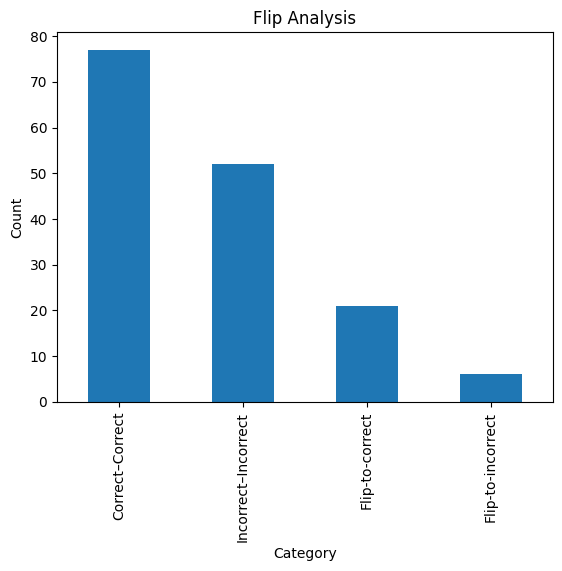

In [ ]:
import matplotlib.pyplot as plt

flip_analysis = df2['category'].value_counts()


flip_analysis.plot.bar()
plt.title('Flip Analysis')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [ ]:
df2['category'].value_counts()

,count
category,
Correct–Correct,77
Incorrect–Incorrect,52
Flip-to-correct,21
Flip-to-incorrect,6


In [ ]:
incorrect_incorrect = df2[df2['category'] == "Incorrect–Incorrect"]
correct_correct = df2[df2['category'] == 'Correct–Correct']
flip_to_correct = df2[df2['category'] == 'Flip-to-correct']
flip_to_incorrect = df2[df2['category'] == 'Flip-to-incorrect']



In [ ]:
incorrect_incorrect.to_csv('incorrect_incorrect.csv')
incorrect_incorrect_sample = incorrect_incorrect.sample(n=20)
incorrect_incorrect_sample.to_csv('incorrect_incorrect_sample.csv')
incorrect_incorrect

,Unnamed: 0,image,question,choices,answer,hint,task,grade,subject,topic,...,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter,CoT_result,reasoning,predicted_letter_CoT,correct/incorrect_CoT
6,9907,NaN,How long is a kitchen table?,"['8 yards', '8 miles', '8 inches', '8 feet']",3,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,...,Measurements are written with both a number an...,The best estimate for the length of a kitchen ...,C,0,C,D,Reasoning:A kitchen table is 8 inches long. Th...,A kitchen table is 8 inches long.,C,0
8,9435,NaN,What do these two changes have in common?\nwat...,"['Both are caused by cooling.', 'Both are caus...",1,NaN,closed choice,grade4,natural science,chemistry,...,Chemical changes and physical changes are two ...,Step 1: Think about each change.\nWater evapor...,(D),0,D,B,Reasoning:Water evaporating from a lake causes...,Water evaporating from a lake causes cooling. ...,D,0
17,7468,NaN,Select the solid.,"['milk', 'water in a fishbowl', 'rain puddle',...",3,NaN,closed choice,grade3,natural science,physics,...,"Solid, liquid, and gas are states of matter. M...",The water in a fishbowl is a liquid. A liquid ...,A,0,A,D,Reasoning:Milk is a solid. The final answer: (A).,Milk is a solid.,A,0
21,10098,NaN,Select the invertebrate.,"['rockfish', 'green frog', 'Canadian lynx', 'm...",3,"Hint: Insects, spiders, and worms are inverteb...",closed choice,grade5,natural science,biology,...,Vertebrates and invertebrates are both groups ...,A monarch butterfly is an insect. Like other i...,(A),0,A,D,Reasoning:Rockfishes are invertebrates. Rockfi...,Rockfishes are invertebrates. Rockfishes are a...,B,0
24,2766,NaN,Which type of sentence is this?\nLester took s...,"['compound', 'complex', 'simple', 'compound-co...",2,NaN,closed choice,grade9,language science,grammar,...,A clause is a group of words that contains bot...,The sentence is simple. It is a single indepen...,(A),0,A,C,Reasoning:Table Mountain is a mountain. Panora...,Table Mountain is a mountain. Panoramic photog...,B,0
25,3298,NaN,What do these two changes have in common?\ntea...,"['Both are caused by heating.', 'Both are caus...",2,NaN,closed choice,grade3,natural science,chemistry,...,Chemical changes and physical changes are two ...,Step 1: Think about each change.\nTearing a pi...,(D),0,D,C,Reasoning:Tending a piece of paper butter melt...,Tending a piece of paper butter melts on a hot...,D,0
31,8531,NaN,Select the invertebrate.,"['castor bean tick', 'zebra dove', 'Solomon le...",0,"Hint: Insects, spiders, and worms are inverteb...",closed choice,grade5,natural science,biology,...,Vertebrates and invertebrates are both groups ...,"A zebra dove is a bird. Like other birds, a ze...",C,0,C,A,Reasoning:Solomon leaf frog is an invertebrate...,Solomon leaf frog is an invertebrate.,C,0
32,12218,NaN,What do these two changes have in common?\nwat...,"['Both are caused by cooling.', 'Both are chem...",3,NaN,closed choice,grade4,natural science,chemistry,...,Chemical changes and physical changes are two ...,Step 1: Think about each change.\nWater evapor...,(A),0,A,D,Reasoning:Water evaporating from a lake causes...,Water evaporating from a lake causes cooling. ...,B,0
35,4672,NaN,Which of these things did the Thirteen Colonie...,"['their own national bank', 'their own nationa...",2,NaN,closed choice,grade4,social science,us-history,...,NaN,"At the start of the Revolutionary War, the col...",D,0,D,C,Reasoning:The Thirteen Colonies had their own ...,The Thirteen Colonies had their own national n...,D,0
37,358,NaN,Select the vertebrate.,"['green iguana', 'julia butterfly', 'black orb...",0,"Hint: Mammals, birds, fish, reptiles, and amph...",closed choice,grade5,natural science,biology,...,Vertebrates and invertebrates are both groups ...,"A bull ant is an insect. Like other insects, a...",(C),0,C,A,Reasoning:Vertebrates are a group of vertebrat...,Vertebrates are a group of vertebrates.,C,0


In [ ]:
correct_correct.to_csv('correct_correct.csv')
correct_correct_sample = correct_correct.sample(n=20)
correct_correct_sample.to_csv('correct_correct_sample.csv')
correct_correct

,Unnamed: 0,image,question,choices,answer,hint,task,grade,subject,topic,...,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter,CoT_result,reasoning,predicted_letter_CoT,correct/incorrect_CoT
1,3808,NaN,Select the living thing.,"['cell phone', 'giant clam', 'paper airplane',...",1,NaN,closed choice,grade4,natural science,biology,...,All living things are made up of cells. Plants...,Clay is not a living thing.\nClay does not hav...,B,1,B,B,Reasoning:Giant clam is a living thing. Giant ...,Giant clam is a living thing. Giant clam can b...,B,1
2,6573,NaN,How long is an adult alligator?,"['15 inches', '15 miles', '15 feet', '15 yards']",2,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,...,Measurements are written with both a number an...,The best estimate for the length of an adult a...,C,1,C,C,Reasoning:Adult alligators are about 15 inches...,Adult alligators are about 15 inches long.,C,1
3,3574,NaN,Which type of sentence is this?\nAs Dan sat do...,"['simple', 'compound-complex', 'compound', 'co...",3,NaN,closed choice,grade8,language science,grammar,...,A clause is a group of words that contains bot...,The sentence is complex. It is made up of an i...,(D),1,D,D,Reasoning:The chair collapsed beneath Dan when...,The chair collapsed beneath Dan when he sat do...,D,1
4,10363,NaN,Which type of sentence is this?\nLorraine Hans...,"['compound', 'complex', 'simple', 'compound-co...",0,NaN,closed choice,grade10,language science,grammar,...,A clause is a group of words that contains bot...,The sentence is compound. It is made up of two...,(A),1,A,A,Reasoning:A Raisin in the Sun is a 1959 Broadw...,A Raisin in the Sun is a 1959 Broadway play wr...,A,1
9,4302,NaN,Which organ provides a barrier against contami...,"['skin', 'stomach', 'brain', 'muscles']",0,NaN,closed choice,grade5,natural science,biology,...,NaN,NaN,(A),1,A,A,Reasoning:Skin provides a barrier against cont...,Skin provides a barrier against contaminants f...,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,8750,NaN,How long is a garden snail?,"['38 kilometers', '38 millimeters', '38 meters...",1,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,...,Measurements are written with both a number an...,The best estimate for the length of a garden s...,(B),1,B,B,Reasoning:Snails are 38 millimeters long. The ...,Snails are 38 millimeters long.,B,1
196,11748,NaN,What do these two changes have in common?\ncoo...,"['Both are chemical changes.', 'Both are only ...",0,NaN,closed choice,grade8,natural science,chemistry,...,Matter is made of very small particles called ...,Step 1: Think about each change.\nCooking an e...,(A),1,A,A,Reasoning:Egg rust forms when the egg is cooke...,Egg rust forms when the egg is cooked.,A,1
197,11290,NaN,Select the reptile.,"['green sea turtle', 'salmon', 'green tree fro...",0,NaN,closed choice,grade5,natural science,biology,...,"Reptiles have scaly, waterproof skin. Most rep...","A green sea turtle is a reptile. It has scaly,...",A,1,A,A,Reasoning:Green sea turtle is a reptile. The f...,Green sea turtle is a reptile.,A,1
198,9075,NaN,What do these two changes have in common?\nsal...,"['Both are chemical changes.', 'Both are only ...",0,NaN,closed choice,grade7,natural science,chemistry,...,Matter is made of very small particles called ...,Step 1: Think about each change.\nSaliva break...,(A),1,A,A,Reasoning:Bacteria breaks down a piece of brea...,Bacteria breaks down a piece of bread and silv...,A,1


In [ ]:
flip_to_correct.to_csv('flip_to_correct.csv')
flip_to_correct_sample = flip_to_correct.sample(n=20)
flip_to_correct_sample.to_csv('flip_to_correct_sample.csv')
flip_to_correct

,Unnamed: 0,image,question,choices,answer,hint,task,grade,subject,topic,...,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter,CoT_result,reasoning,predicted_letter_CoT,correct/incorrect_CoT
10,4130,NaN,Select the bird.,"['grass frog', 'arroyo toad', 'penguin', 'cora...",2,NaN,closed choice,grade5,natural science,biology,...,"Birds have feathers, two wings, and a beak.","A coral snake is a reptile. It has scaly, wate...",A,0,A,C,Reasoning:A penguin is a species of bird. The ...,A penguin is a species of bird.,C,1
19,10921,NaN,Select the vertebrate.,"['redback spider', 'human', 'grasshopper', 'sa...",1,"Hint: Mammals, birds, fish, reptiles, and amph...",closed choice,grade4,natural science,biology,...,Vertebrates and invertebrates are both groups ...,A saturn butterfly is an insect. Like other in...,A,0,A,B,Reasoning:Vertebrates are the only living bein...,Vertebrates are the only living beings. Humans...,B,1
20,6428,NaN,How long is a ladybug?,"['9 meters', '9 kilometers', '9 millimeters', ...",2,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,...,Measurements are written with both a number an...,The best estimate for the length of a ladybug ...,D,0,D,C,Reasoning:A ladybug is 9 cm long. The final an...,A ladybug is 9 cm long.,C,1
45,8233,NaN,Complete the sentence.\nThe Eighth Amendment s...,"['cruel and unusual', 'embarrassing', 'violent...",0,NaN,closed choice,grade4,social science,civics,...,NaN,"Today, the United States often uses punishment...",(C),0,C,A,Reasoning:The Eighth Amendment says that the g...,The Eighth Amendment says that the government ...,A,1
53,12050,NaN,Select the reptile.,"['domestic pig', 'tortoise', 'leafy seadragon'...",1,NaN,closed choice,grade5,natural science,biology,...,"Reptiles have scaly, waterproof skin. Most rep...",A leafy seadragon is a fish. It lives underwat...,D,0,D,B,Reasoning:American toad is a reptile. The fina...,American toad is a reptile.,B,1
56,6639,NaN,Select the animal.,"['Oak trees can have thick branches.', 'Cherry...",2,NaN,closed choice,grade3,natural science,biology,...,Plants and animals are living things. Living t...,An oak tree is a plant. It can have thick bran...,D,0,D,C,Reasoning:Oak trees can have thick branches. Y...,Oak trees can have thick branches. Yellow jack...,C,1
71,9135,NaN,How long is a caterpillar?,"['24 millimeters', '24 kilometers', '24 meters...",0,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,...,Measurements are written with both a number an...,The best estimate for the length of a caterpil...,D,0,D,A,Reasoning:A caterpillar is 24 millimeters long...,A caterpillar is 24 millimeters long.,A,1
75,2208,NaN,Which type of sentence is this?\nLeonardo da V...,"['compound', 'complex', 'compound-complex', 's...",1,NaN,closed choice,grade10,language science,grammar,...,A clause is a group of words that contains bot...,The sentence is complex. It is made up of an i...,(A),0,A,B,Reasoning:Leonardo da Vinci was a painter and ...,Leonardo da Vinci was a painter and sculptor. ...,B,1
92,4498,NaN,What do these two changes have in common?\nan ...,"['Both are only physical changes.', 'Both are ...",1,NaN,closed choice,grade4,natural science,chemistry,...,Chemical changes and physical changes are two ...,Step 1: Think about each change.\nAn iceberg m...,(D),0,D,B,Reasoning:Iceberg melting slowly causes coolin...,Iceberg melting slowly causes cooling.,B,1
98,7764,NaN,Where was Thomas Jefferson from?,"['Pennsylvania', 'Virginia', 'England', 'Canada']",1,NaN,closed choice,grade3,social science,us-history,...,NaN,Thomas Jefferson was from Virginia.\nVirginia ...,(C),0,C,B,Reasoning:Virginia is a state in the United St...,Virginia is a state in the United States. Thom...,B,1


In [ ]:
flip_to_incorrect.to_csv('flip_to_incorrect.csv')
flip_to_incorrect

,Unnamed: 0,image,question,choices,answer,hint,task,grade,subject,topic,...,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter,CoT_result,reasoning,predicted_letter_CoT,correct/incorrect_CoT
11,8088,NaN,When was Harriet Tubman born?,"['the 1820s', 'the 1610s', 'the 1910s', 'the 1...",0,NaN,closed choice,grade3,social science,us-history,...,NaN,Harriet Tubman was born in the 1820 s. She was...,(A),1,A,A,Reasoning:Harriet Tubman was born in the 1610s...,Harriet Tubman was born in the 1610s.,B,0
66,2676,NaN,Which type of sentence is this?\nJulie is a co...,"['compound-complex', 'complex', 'compound', 's...",0,NaN,closed choice,grade10,language science,grammar,...,A clause is a group of words that contains bot...,The sentence is compound-complex. It is made u...,(A),1,A,A,Reasoning:Equestrian Games are held every four...,Equestrian Games are held every four years.,B,0
95,2953,NaN,How long is a raisin?,"['10 meters', '10 centimeters', '10 kilometers...",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,...,Measurements are written with both a number an...,The best estimate for the length of a raisin i...,D,1,D,D,Reasoning:A raisin has a length of 10 millimet...,A raisin has a length of 10 millimeters.,B,0
109,6310,NaN,How long is a spider's leg?,"['18 meters', '18 centimeters', '18 kilometers...",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,...,Measurements are written with both a number an...,The best estimate for the length of a spider's...,D,1,D,D,Reasoning:A spider's leg is 18 millimeters lon...,A spider's leg is 18 millimeters long.,B,0
111,3096,NaN,Which type of sentence is this?\nAs Johnny sat...,"['simple', 'compound', 'complex', 'compound-co...",2,NaN,closed choice,grade7,language science,grammar,...,A clause is a group of words that contains bot...,The sentence is complex. It is made up of an i...,(C),1,C,C,Reasoning:The chair collapsed beneath Johnny b...,The chair collapsed beneath Johnny because it ...,B,0
116,11138,NaN,How long is the Great Wall of China?,"['13,000 feet', '13,000 inches', '13,000 yards...",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,...,Measurements are written with both a number an...,The best estimate for the length of the Great ...,D,1,D,D,Reasoning:The length of the Great Wall of Chin...,"The length of the Great Wall of China is 13,00...",A,0


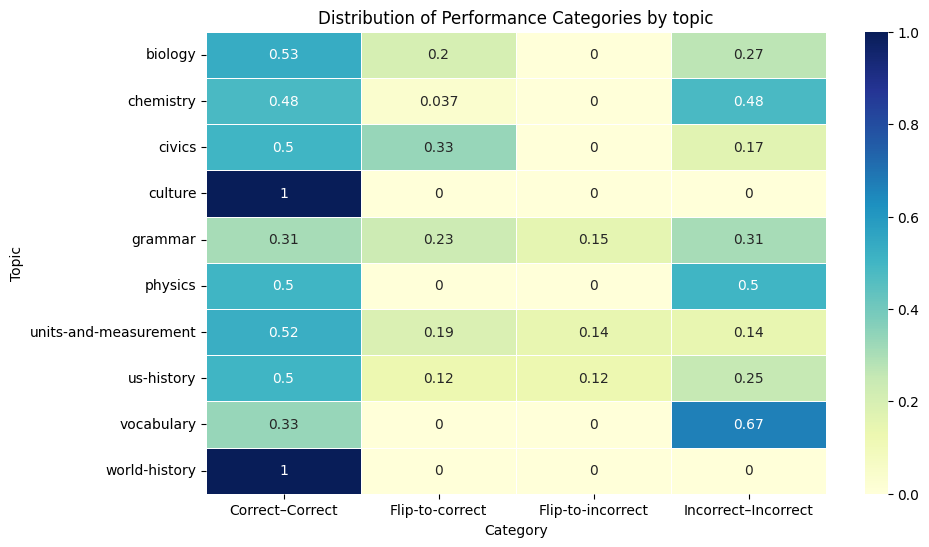

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a frequency table (Crosstab)
# Index = subject, Columns = category
heatmap_data = pd.crosstab(df2['topic'], df2['category'], normalize='index')

# 2. (Optional) Reorder columns for a logical flow:
# Stable Correct -> Improvement -> Decline -> Stable Incorrect
cols_order = ['Correct–Correct', 'Flip-to-correct', 'Flip-to-incorrect', 'Incorrect–Incorrect']
heatmap_data = heatmap_data.reindex(columns=cols_order)

# 3. Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data,
            annot=True,      # Shows the numbers in the cells
            cmap='YlGnBu',   # Color palette (Yellow-Green-Blue)
            linewidths=.5)

plt.title('Distribution of Performance Categories by topic')
plt.ylabel('Topic')
plt.xlabel('Category')
plt.show()

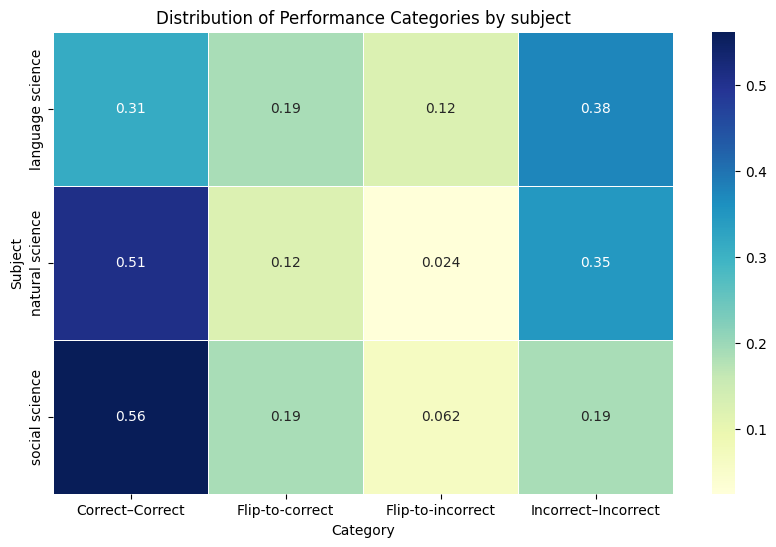

In [ ]:


# 1. Create a frequency table (Crosstab)
# Index = subject, Columns = category
heatmap_data = pd.crosstab(df2['subject'], df2['category'], normalize='index')

# 2. (Optional) Reorder columns for a logical flow:
# Stable Correct -> Improvement -> Decline -> Stable Incorrect
cols_order = ['Correct–Correct', 'Flip-to-correct', 'Flip-to-incorrect', 'Incorrect–Incorrect']
heatmap_data = heatmap_data.reindex(columns=cols_order)

# 3. Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data,
            annot=True,      # Shows the numbers in the cells
            cmap='YlGnBu',   # Color palette (Yellow-Green-Blue)
            linewidths=.5)

plt.title('Distribution of Performance Categories by subject')
plt.ylabel('Subject')
plt.xlabel('Category')
plt.show()

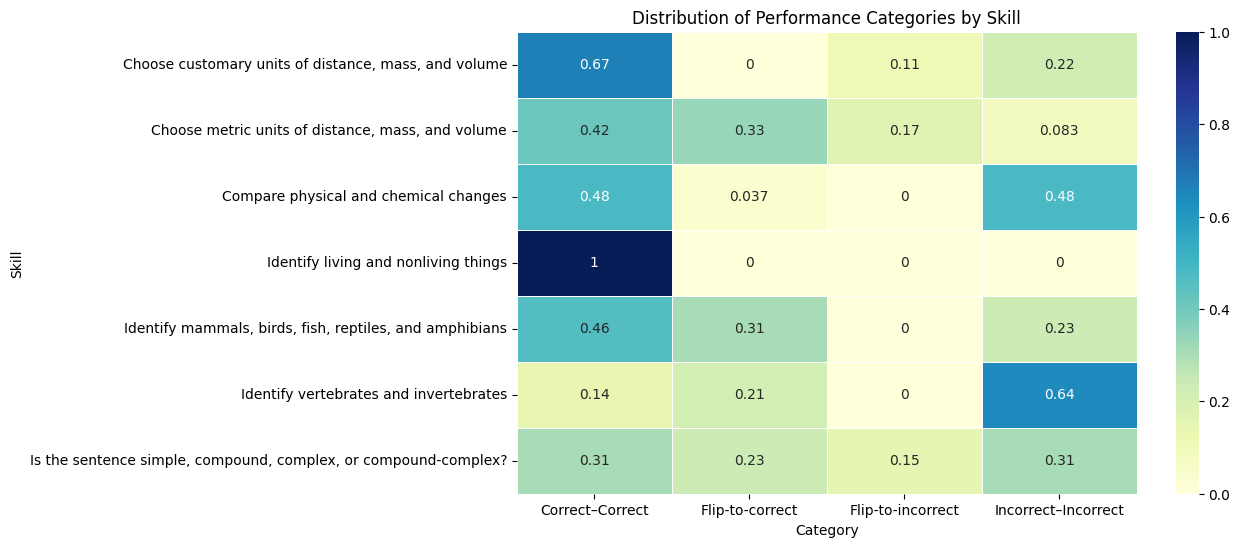

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Keep only skills that occur more than once
skill_counts = df2['skill'].value_counts()
valid_skills = skill_counts[skill_counts > 5].index

df2_filtered = df2[df2['skill'].isin(valid_skills)]

# 2. Crosstab on filtered data
heatmap_data = pd.crosstab(
    df2_filtered['skill'],
    df2_filtered['category'],
    normalize='index'
)

# 3. Reorder columns
cols_order = ['Correct–Correct', 'Flip-to-correct', 'Flip-to-incorrect', 'Incorrect–Incorrect']
heatmap_data = heatmap_data.reindex(columns=cols_order)

# 4. Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='YlGnBu',
    linewidths=.5
)

plt.title('Distribution of Performance Categories by Skill')
plt.ylabel('Skill')
plt.xlabel('Category')
plt.show()

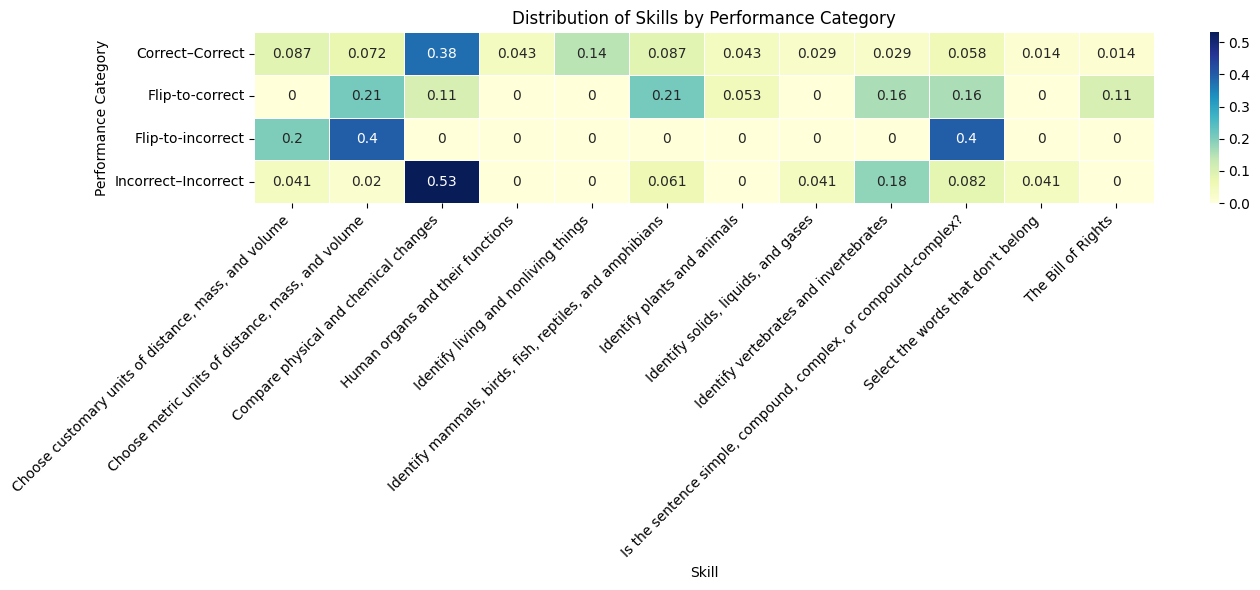

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Keep only skills that occur more than once
skill_counts = df2['skill'].value_counts()
valid_skills = skill_counts[skill_counts > 1].index

df2_filtered = df2[df2['skill'].isin(valid_skills)]

# 2. Crosstab: category → skill
heatmap_data = pd.crosstab(
    df2_filtered['category'],
    df2_filtered['skill'],
    normalize='index'   # normalize within each category
)

# 3. (Optional) reorder categories
rows_order = ['Correct–Correct', 'Flip-to-correct', 'Flip-to-incorrect', 'Incorrect–Incorrect']
heatmap_data = heatmap_data.reindex(rows_order)

# 4. Plot
plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='YlGnBu',
    linewidths=.5
)

plt.title('Distribution of Skills by Performance Category')
plt.ylabel('Performance Category')
plt.xlabel('Skill')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [13]:
skill_counts = df2['skill'].value_counts()

print(skill_counts)


skill
Compare physical and chemical changes                              54
Identify vertebrates and invertebrates                             14
Identify mammals, birds, fish, reptiles, and amphibians            13
Is the sentence simple, compound, complex, or compound-complex?    13
Choose metric units of distance, mass, and volume                  12
Identify living and nonliving things                               10
Choose customary units of distance, mass, and volume                9
Identify solids, liquids, and gases                                 4
Identify plants and animals                                         4
Human organs and their functions                                    3
The Bill of Rights                                                  3
Select the words that don't belong                                  3
Harriet Tubman                                                      1
The Constitution                                                    1
The War of 181

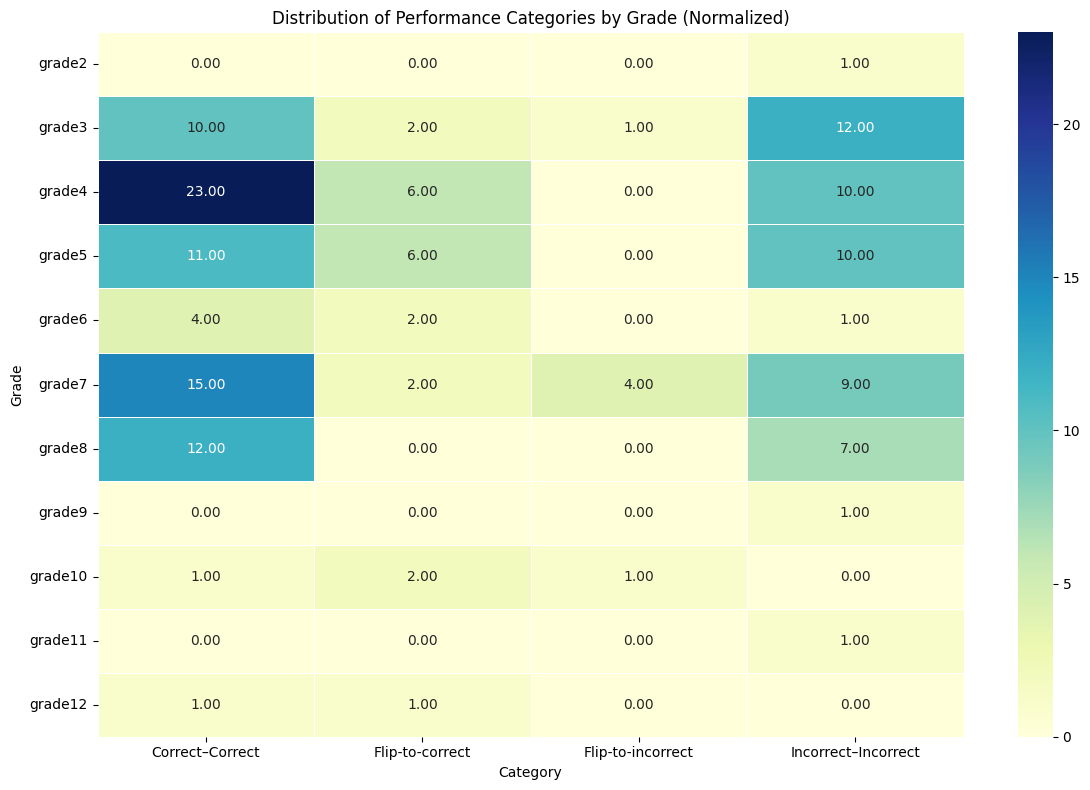

In [14]:
import re

# 1. Create a frequency table (Crosstab)
heatmap_data = pd.crosstab(df2['grade'], df2['category'])

# 2. Reorder Columns logically
cols_order = ['Correct–Correct', 'Flip-to-correct', 'Flip-to-incorrect', 'Incorrect–Incorrect']
# Filter cols_order to only include columns that actually exist in the data to avoid errors
existing_cols = [c for c in cols_order if c in heatmap_data.columns]
heatmap_data = heatmap_data.reindex(columns=existing_cols)

# 3. Reorder Rows (Grades) numerically
# Extract the number from the grade string (e.g., 'grade10' -> 10) and sort by that number
sorted_grades = sorted(heatmap_data.index, key=lambda x: int(re.search(r'\d+', x).group()))
heatmap_data = heatmap_data.reindex(index=sorted_grades)

# 4. Plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data,
            annot=True,
            fmt='.2f',       # Format as 2-decimal float since data is normalized (0 to 1)
            cmap='YlGnBu',
            linewidths=.5)

plt.title('Distribution of Performance Categories by Grade (Normalized)')
plt.ylabel('Grade')
plt.xlabel('Category')
plt.tight_layout()
plt.show()